### Inserting Libraries

In [3]:
import spotipy
import credentials
from tqdm import tqdm_notebook as tqdm
from spotipy.oauth2 import SpotifyClientCredentials, is_token_expired
import pandas as pd

### Setting up API credentials

In [4]:
# You should create a credentials.py in your repo with credentials in it

In [5]:
client_credentials_manager = SpotifyClientCredentials(client_id=credentials.client_id,client_secret=credentials.client_secret)

In [6]:
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

### Function that given a user_id returns all the data

In [7]:
def get_all_data(user_id):
    
    #get all the playlist id's
    
    track_list = []
    sname_list = []
    artist_list = []
    audio_ft = []
    
        
    for playlist in tqdm(sp.user_playlists(user_id)['items']):
            for idx,track in enumerate(sp.playlist_tracks(playlist['id'])['items']):
                if track['track']['id'] is not None:
                    
                    track_list.append(track['track']['id'])
                    sname_list.append(track['track']['name'])
                    artist_list.append(track['track']['album']['artists'][0])
                    #print(track['track']['id'])
                    audio_ft.append(sp.audio_features(track['track']['id'])[0])
    
    df = pd.DataFrame({'name': sname_list,
                       'artist': artist_list,
                       'id': track_list,
                       'audio_ft': audio_ft})
    
    return df

            

In [8]:
df = get_all_data('11101312700')

/home/tomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [9]:
# Time to transform the data in order to be clean

In [10]:
def transform_data(df):
    
    df['artist'] = df['artist'].apply(pd.Series)['name']
    
    df = pd.concat([df,df['audio_ft'].apply(pd.Series)], axis=1)
    
    df = df.drop(labels=['time_signature','duration_ms','analysis_url','uri','track_href','type','audio_ft'], axis=1)
    
    return df
    
    
    

In [11]:
df = transform_data(df)

In [12]:
df.head()

,name,artist,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id
0,Brokendate,Com Truise,2kmX8QNMLg72Vy9Ux6mdmi,0.526,0.544,11,-7.137,1,0.1690,0.25800,0.640000,0.3770,0.544,170.370,2kmX8QNMLg72Vy9Ux6mdmi
1,Crimewave,Crystal Castles,3yQFmN8A5S8Kf1nUJuvb01,0.746,0.691,4,-7.533,0,0.0403,0.18400,0.025900,0.2050,0.888,119.982,3yQFmN8A5S8Kf1nUJuvb01
2,Vanished,Crystal Castles,0exOxvY3iHsmAnGHiJYAZq,0.713,0.868,0,-6.644,0,0.0305,0.00206,0.000092,0.2250,0.641,119.980,0exOxvY3iHsmAnGHiJYAZq
3,Lady - Hear Me Tonight,Modjo,49X0LAl6faAusYq02PRAY6,0.720,0.808,6,-5.627,1,0.0379,0.00793,0.029300,0.0634,0.869,126.041,49X0LAl6faAusYq02PRAY6
4,Baby I'm Yours,Breakbot,0tZkVZ9DeAa0MNK2gY5NtV,0.829,0.792,2,-3.755,0,0.0668,0.72600,0.000006,0.1220,0.758,118.050,0tZkVZ9DeAa0MNK2gY5NtV


Now we have all the songs of our playlist in a data frame with each audio feature, time to do some magic

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [15]:
features = ['danceability','energy','loudness','acousticness'
           ,'instrumentalness','valence']

In [16]:
scaler = MinMaxScaler()

scaled = pd.DataFrame(scaler.fit_transform(df[features]))
scaled.columns = features


In [17]:
def calculate_wcss(data):
    wcss = []
    for n in range(1, 15):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

In [18]:
wcss = calculate_wcss(scaled)

In [19]:
len(wcss)

14

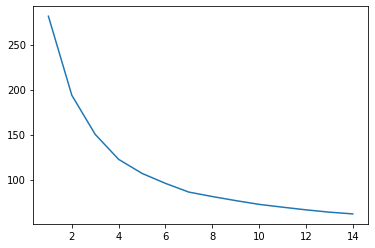

In [20]:
sns.lineplot(x=range(1,15), y=wcss)

In [60]:
kmeans = KMeans(n_clusters=5).fit(scaled)

In [61]:
y_kmeans = kmeans.predict(scaled)

In [62]:
centroids = kmeans.cluster_centers_
centroids

array([[0.5496698 , 0.36237016, 0.55586297, 0.62573044, 0.81458333,
        0.23432397],
       [0.66473237, 0.74860897, 0.78545493, 0.13816253, 0.01691134,
        0.71102244],
       [0.53420605, 0.38400609, 0.60821013, 0.67862542, 0.02689699,
        0.32974131],
       [0.5249988 , 0.68712898, 0.77513609, 0.09991271, 0.02968767,
        0.30465196],
       [0.6406225 , 0.71030456, 0.73928583, 0.08554763, 0.79862939,
        0.57907728]])

In [63]:
scaled = scaler.fit_transform(scaled)

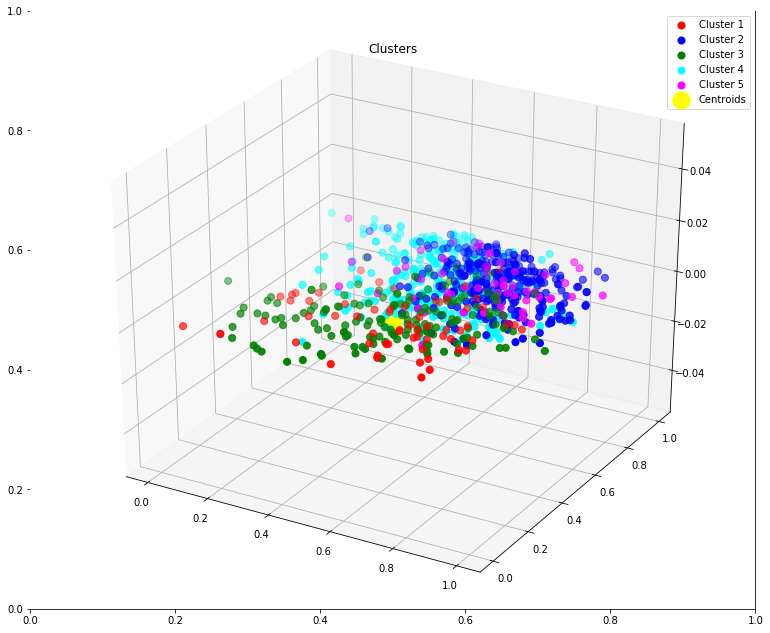

In [64]:
from mpl_toolkits.mplot3d import Axes3D
# visualizing clusters
fig, ax = plt.subplots(figsize=(13,11))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(scaled[y_kmeans == 0,0],scaled[y_kmeans == 0,1], s= 50, c= 'red',label= 'Cluster 1')
plt.scatter(scaled[y_kmeans == 1,0], scaled[y_kmeans == 1,1], s= 50, c= 'blue', label= 'Cluster 2')
plt.scatter(scaled[y_kmeans == 2,0], scaled[y_kmeans == 2,1], s= 50, c= 'green', label= 'Cluster 3')
plt.scatter(scaled[y_kmeans == 3,0], scaled[y_kmeans == 3,1], s= 50, c= 'cyan', label= 'Cluster 4')
plt.scatter(scaled[y_kmeans == 4,0], scaled[y_kmeans == 4,1], s= 50, c= 'magenta', label= 'Cluster 5')


# centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s= 300, c= 'yellow', label= 'Centroids')
plt.title('Clusters')
plt.legend()
plt.show()

In [65]:
kmeans_pred = pd.DataFrame(data=y_kmeans, dtype=int, columns=['k_cluster'])
kmeans_pred

,k_cluster
0,4
1,1
2,1
3,1
4,1
...,...
872,1
873,1
874,1
875,2


In [66]:
df_cluster = pd.concat([df, kmeans_pred], axis = 1)

In [67]:
cluster_0 = df_cluster[df_cluster.k_cluster == 0][features].mean()

In [68]:
labels = cluster_0.index
stats = cluster_0.values

In [70]:
cluster_stats = pd.DataFrame(columns=features)
for n in range(5):   
    cluster_stats = cluster_stats.append(df_cluster[df_cluster.k_cluster == n][features].mean(), ignore_index=True)
       
cluster_stats


,danceability,energy,loudness,acousticness,instrumentalness,valence
0,0.559694,0.377560,-12.696871,0.620726,0.782000,0.256206
1,0.662997,0.750357,-6.210898,0.137060,0.016235,0.706830
2,0.545810,0.398443,-11.218064,0.673197,0.025821,0.346404
3,0.537544,0.691017,-6.502405,0.099116,0.028500,0.322687
4,0.641351,0.713386,-7.515175,0.084866,0.766684,0.582102


In [71]:
from math import pi

In [76]:
def make_spider(df, row, color):
    
    categories=list(df)[0:]
    N = len(categories)

    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
     
    plt.rc('figure', figsize=(7, 7))
 
    ax = plt.subplot(1,1,1, polar=True)
 
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
 
   
    plt.xticks(angles[:-1], categories, color='black', size=12)
    ax.tick_params(axis='x', rotation=5.5)
    
    ax.set_rlabel_position(0)
    plt.yticks([0.3,0.6,0.8,1], ["0.3","0.6","0.8","1"], color="black", size=10)
    plt.ylim(0,0.8)
 
    
    values=df.reset_index().loc[row].values.tolist()[1:]
    values += values[:1]
    ax.plot(angles, values, color = color, linewidth=1, linestyle='solid')
    ax.fill(angles, values, color = color, alpha = 0.5)
 
  
    title = "Cluster {}".format(row)
    plt.title(title, fontsize=20, x = 0.5, y = 1.1)
 

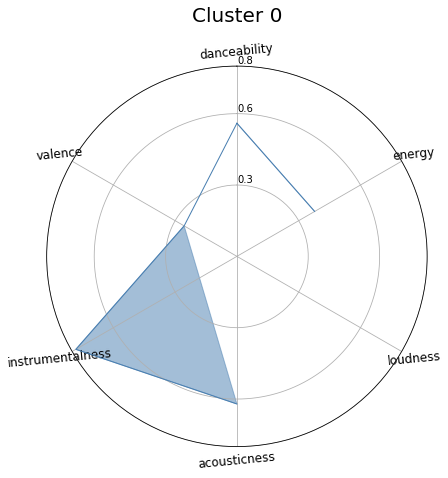

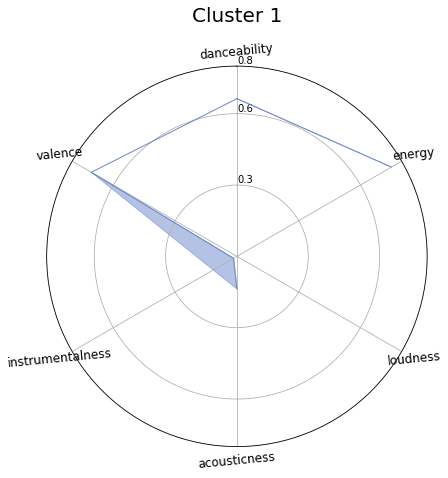

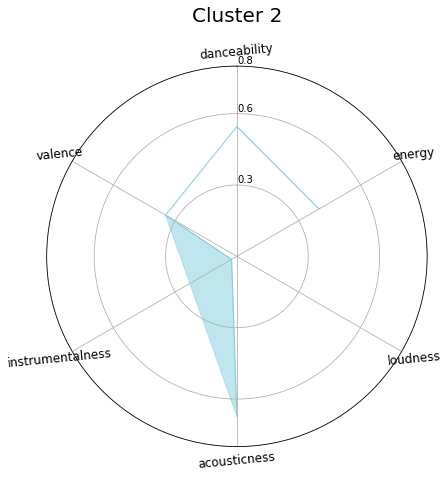

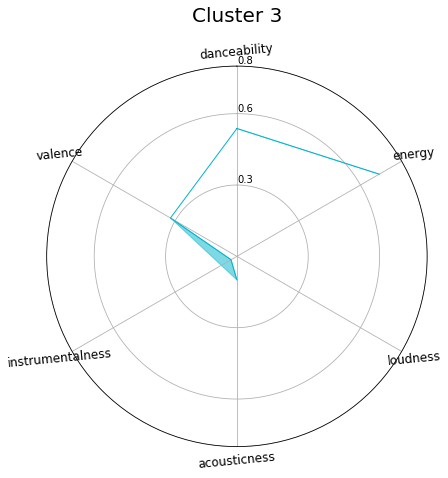

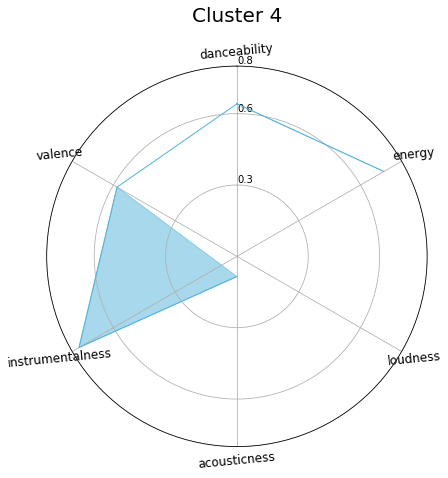

In [77]:
fills = ["#487eb0","#6a89cc", "#81cfe0","#00b5cc","#52b3d9"]
for row in range(0, len(cluster_stats.index)):
    plt.figure()
    make_spider( row=row, df = cluster_stats, color = fills[row])

In [164]:
df_cluster[df_cluster.k_cluster == 0]['id']

,id,id
1,3yQFmN8A5S8Kf1nUJuvb01,3yQFmN8A5S8Kf1nUJuvb01
3,49X0LAl6faAusYq02PRAY6,49X0LAl6faAusYq02PRAY6
5,25SJaCCPiosugnlY53VhRG,25SJaCCPiosugnlY53VhRG
8,5r5cp9IpziiIsR6b93vcnQ,5r5cp9IpziiIsR6b93vcnQ
9,6gV4xPbvYJz73lA1cr4NhH,6gV4xPbvYJz73lA1cr4NhH
...,...,...
868,6Ius4TC0L3cN74HT7ENE6e,6Ius4TC0L3cN74HT7ENE6e
869,33ZXjLCpiINn8eQIDYEPTD,33ZXjLCpiINn8eQIDYEPTD
872,7iXF2W9vKmDoGAhlHdpyIa,7iXF2W9vKmDoGAhlHdpyIa
873,7GkrhcYfflOImusWPIFrPN,7GkrhcYfflOImusWPIFrPN


In [168]:
df_cluster = df_cluster.loc[:,~df_cluster.columns.duplicated()]

In [170]:
df_cluster[df_cluster.k_cluster == 0]['id'].to_list()

['3yQFmN8A5S8Kf1nUJuvb01',
 '49X0LAl6faAusYq02PRAY6',
 '25SJaCCPiosugnlY53VhRG',
 '5r5cp9IpziiIsR6b93vcnQ',
 '6gV4xPbvYJz73lA1cr4NhH',
 '4DX82Vc8qAH4jJPvKxvwg6',
 '0BgY6O6G7EtsneY6dAKZeI',
 '6NiIHp4nhuHkcc4rZxctyF',
 '1ueLYdeuGMAwUiaezLDObD',
 '0d28khcov6AiegSCpG5TuT',
 '0dcMqjeDpwqB2xhzMsld0p',
 '69dXVFCMiz3SL1L7M24NdX',
 '5r5cp9IpziiIsR6b93vcnQ',
 '5ByAIlEEnxYdvpnezg7HTX',
 '0D8Npw3PzW1srmITkELL3s',
 '7GkrhcYfflOImusWPIFrPN',
 '119c93MHjrDLJTApCVGpvx',
 '2MQ51y5NhCyva4SgWmK2Me',
 '4INDiWSKvqSKDEu7mh8HFz',
 '5XLC8xoqyua4U7wJiZAWik',
 '0zUaNkEcOiAE4cE0V5sA9u',
 '4nH38LBCP7sCdIkv23jJwc',
 '5hl9wX67vKKzT2nBO0B2BE',
 '3EAbMbWQmh6f04u2Kh7wTH',
 '0hI7haTwP7pek8WFQjDZoQ',
 '4nGdVw9wXIeY4gOhsUNH1L',
 '06b0Au6pvZiO03eKTCvgWh',
 '7d5cCdTZavXBFao9lCScjo',
 '7x4ClpwHSyNJgCsMUFRVU7',
 '04eL7Mun5wCThY3P37onK4',
 '7w7wTfCkR2ML44Z6Ingz9d',
 '77E6BhaBLsIMmW5nAyXGTy',
 '3tMNgcUfPEXTtG5vaaGi85',
 '49rFA0vfmY9Eel2cInKmTk',
 '7MCFjPDImfjQv7GynHgVrR',
 '0qPbQWcqNDVrReSSvMoJxk',
 '4shKoD4U0rsE6UDjyPEjyK',
 

In [ ]:
def create_cluster_playlist(df):
    
    for num in range()

In [179]:
for num in range(0,len(df_cluster['k_cluster'].value_counts().index)):
    sp.user_playlist_create(user,name='Cluster{}'.format(num), public=True,
                           description="Playlist generated by KMeans Algorithm")
    sp.user_playlist_add_tracks()

0
1
2
3
4


In [202]:
df_cluster[df_cluster.k_cluster == 4]['name'].to_list()

['Shooting Stars',
 'Como se siente',
 'Maquiavélico',
 'Heartless',
 'Avoid',
 'Dear Mama',
 'Changes',
 'Kawasaki',
 'Nadie',
 'Shorty',
 "Sam's Town",
 'When You Were Young',
 'Uncle Jonny',
 'Do I Wanna Know?',
 'The View From The Afternoon',
 'From The Ritz To The Rubble',
 'Californication',
 'In My Feelings',
 'U Said',
 'Beamer Boy',
 'Monophobia',
 'Survival',
 'Better Now',
 'Slide Away - Remastered',
 'The Final Countdown',
 'On & On',
 'Lucid Dreams',
 'Ghost Town',
 'Perdóname',
 'U Said',
 'Cinderella (feat. Ty Dolla $ign)',
 'Ladders',
 'Somebody',
 'STOP TRYING TO BE GOD',
 'In My Feelings',
 'Magnolia',
 'Better Now',
 'Guerra',
 'Beamer Boy',
 'Insane',
 'You & Me - Flume Remix',
 'Will I Ever Care',
 'Midnight',
 'There for You',
 'Breeze',
 'Disappear',
 'Breathe Again',
 'Hurt',
 'Kaleidoscope Kickback',
 'American Dream',
 'Shoulda Coulda',
 'lockdown',
 'Sorry',
 'Flurry',
 'Forever',
 'Close to Me',
 'Chasing California',
 'In the Name of Love',
 'Something Just